# Adversarial image generation in Tensorflow

To understand the idea behind aversarial training I read this [blog post](http://evjang.com/articles/genadv1). This post tries to make you think about it as a probabilistic problem, but don't, it's just about coming up with a convincing optimization problem, e.g. if you replace 

$$ \log{D(x)} + \log{1.0 - D(G(z))}$$

by 

$$ D(x) - D(G(z))$$

it will probably still work fine. OK, I'll stop complaining now.

The actual architecture and choice of dataset is inspired by [this paper](http://arxiv.org/abs/1511.06434). There's also corresponding Theano code, but it's [insane](https://github.com/Newmu/dcgan_code) (no that I am any better...).

Get the data from [here](https://github.com/fyu/lsun). Since it is not insane (except from the fact that you need to unpack that giant zip), I will not give further instructions on the data download procedure.

In [1]:
import pickle
import os
import numpy as np
import tensorflow as tf
import time
import random
import lmdb
import io

from IPython.display import clear_output
from itertools import count
from PIL import Image

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Data loading ([here](https://github.com/fyu/lsun))

Just like in the paper I used the badrooms dataset. Unlike in the paper I did not use any image deduplication. The simpler the algorithm the better. Every image was scaled down to the resolution of $64 \times 64$. If the image was not a square, I cropped it to the biggest square that fits inside the image which was adjacent to the top-left corner. In theory it might be better to crop to center of the image, but 

![No fucks given](http://i.imgur.com/V1aa0oJ.gif)

In [3]:
# directory to which you unpack the funny 55 GB zip.
DB_PATH = '/home/sidor/datasets/lsun/bedroom_train_lmdb'

In [4]:
def load_image(val):
    """LSUN images are stored as bytes of JPEG representation.
    This function converts those bytes into a a 3D tensor 
    of shape (64,64,3) in range [0.0, 1.0].
    """
    img = Image.open(io.BytesIO(val))
    rp = 64 / min(img.size)
    img = img.resize(np.rint(rp * np.array(img.size)).astype(np.int32), Image.BICUBIC)
    img = img.crop((0,0,64,64))
    img = np.array(img, dtype=np.float32) / 255.
    return img

def iterate_images(start_idx=None):
    """Iterates over the images returns pairs of 
    (index, image_tensor). It is never the case that all the images
    are loaded into memory at the same time (hopefully, lmdb, please?).
    
    give it a start_idx, not to start from the beginning"""
    with lmdb.open(DB_PATH, map_size=1099511627776,
                    max_readers=100, readonly=True) as env:
        with env.begin(write=False) as txn:
            with txn.cursor() as cursor:
                for i, (key, val) in enumerate(cursor):
                    if start_idx is None or start_idx <= i:
                        yield i, load_image(val)

def show_image(img, resize=True):
    """Given a tensor displays it in IPython notebook cell.
    must be the last line. Set resize=False to keep original size."""
    from PIL import Image
    i = Image.fromarray((img * 255.).astype(np.uint8))
    return i.resize((512,512),Image.BICUBIC) if resize else i

### Verifying the data is loaded correctly

Change $42$ to any other number to view a different image. All the ones I eyeballed were actual beds/bedrooms, which is reassuring.

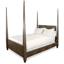

In [5]:
idx, img = next(iterate_images(42))
show_image(img, resize=False)

# Model 

The model is mostly the same as the one in the paper. I used Tensorflows deconv2d; I have not played around with it much but I assume it's an inverse function of a convolution (given the filters). I didn't do batch normalization, leaky relu etc. and frakly I don't believe they matter that much. 

![leaky relu, batch normalization and likes](http://i392.photobucket.com/albums/pp5/sciafb/calling-bullshit.gif)

All that matters is three-fucking-million images and your GPU. 

My image is a tensor in $[0,1]^{H \times W \times 3}$, so I used sigmoid instead of tanh at the last layer of generator. I clip my gradients because otherwise the training is wobbly especially given the fact that Adam sometimes behaves like that:

![Adam optimizer](http://38.media.tumblr.com/3f64d9271cbd4db49c48c949700da02f/tumblr_nchqbi4EIf1s02vreo1_250.gif)

## Notes on actual network architecture

Generator is almost exactly Figure 1 in [the paper](http://arxiv.org/abs/1511.06434), not sure about the filter size though. Discriminator is esentially the reverse. 

## Tenserflow hype

Notice how tensorflow makes the odd stuff very easy - activating two networks, but backpropagating into one. Two different trianing procedures. Variable reuse. Deconvolutions (well to be honset it was hidden from documentation).

In [6]:
# Those take a little bit of code because I made them general 
# for other projects, but they do exactly what you expect them to.
# Layer is a simple Matrix multiply and bias. MLP is a multi-layer perceptron
# both convolutions include the nonlinearities (they really shouldn't
# for consistency, I might clean it up later)
from models import Layer, MLP, ConvLayer, DeconvLayer

In [7]:
def minimize_and_clip(optimizer, objective, var_list, clip_val=5):
    gradients = optimizer.compute_gradients(objective, var_list=var_list)
    for i, (grad, var) in enumerate(gradients):
        if grad is not None:
            gradients[i] = (tf.clip_by_norm(grad, clip_val), var)
    return optimizer.apply_gradients(gradients)

In [8]:
tf.ops.reset_default_graph()       # CAN TENSORFLOW BE BETTER?
if 'session' in globals():         # CAN TENSORFLOW BE BETTER?
    session.close()                # CAN TENSORFLOW BE BETTER?
session = tf.InteractiveSession()  # CAN TENSORFLOW BE BETTER?


# size of the z vector from paper 
GENERATOR_SEED = 100
def generator(in_seed, reuse=False):
    with tf.variable_scope("generator", reuse=reuse):
        g1 = Layer(GENERATOR_SEED, 1024 * 4 * 4, scope="project1")(in_seed)
        g1 = tf.reshape(tf.nn.relu(g1), (-1, 4, 4, 1024))
        # (BATCH, 4, 4, 1024)
        g2 = DeconvLayer(4, 4, 1024, 512, stride=(2,2), scope="dconv1")(g1)
        # (BATCH, 8, 8, 512)
        g3 = DeconvLayer(4, 4, 512, 256,  stride=(2,2),  scope="dconv2")(g2)
        # (BATCH, 16, 16, 256)
        g4 = DeconvLayer(4, 4, 256, 128,  stride=(2,2),  scope="dconv3")(g3)
        # (BATCH, 32, 32, 3)
        g5 = DeconvLayer(4, 4, 128, 3,    stride=(2,2),  scope="dconv4", nonlinearity=tf.nn.sigmoid)(g4)
        # (BATCH, 64, 64, 3)
        return g5

# this is the discriminator (it is abbreviated as discrimin, because it has
# the same number of words as generator and variables align nicely)
def discrimin(in_photo, reuse=False):
    with tf.variable_scope("discrimin", reuse=reuse):
        g0 = ConvLayer(4, 4, 3,   128,  stride=(2,2), scope="conv0")(in_photo)
        # (BATCH, 32, 32, 128)        
        g1 = ConvLayer(4, 4, 128, 256,  stride=(2,2), scope="conv1")(g0)
        # (BATCH, 16, 16, 256)
        g2 = ConvLayer(4, 4, 256, 512,  stride=(2,2), scope="conv2")(g1)
        # (BATCH, 8, 8, 512)
        g3 = ConvLayer(4, 4, 512, 1024, stride=(2,2), scope="conv3")(g2)
        # (BATCH, 4, 4, 1024)
        g3_flat = tf.reshape(g3, (-1, 1024 * 4 * 4))
        g4 = Layer(1024 * 4 * 4, 1, scope="final_project")(g3_flat)
        # (BATCH, 1)
        return tf.nn.sigmoid(g4)

# generator_training
GENERATOR_BATCH = 128 # we need to decide on batch size now, instead of using none
                      # because TF deconvolutions are special.
gen_z           = tf.placeholder(tf.float32, (GENERATOR_BATCH, GENERATOR_SEED,))
gen_score       = tf.reduce_mean(tf.log(discrimin(generator(gen_z))))
generator_vars  = [v for v in tf.all_variables() if v.name.startswith("generator/")]
discrimin_vars  = [v for v in tf.all_variables() if v.name.startswith("discrimin/")]
gen_optimizer   = tf.train.AdamOptimizer(learning_rate=0.0003, beta1=0.5) # beta1=0.5 might not be necessary - try it!
# it is imporant that you specify var_list explicitly - this objective is only optimized w.r.t. generator params.
gen_op          = minimize_and_clip(gen_optimizer, objective=-gen_score, var_list=generator_vars)

# discrimin_training
DISCRIMIN_BATCH = 128 
dis_real_image = tf.placeholder(tf.float32, (DISCRIMIN_BATCH, 64, 64, 3))
dis_z          = tf.placeholder(tf.float32, (DISCRIMIN_BATCH, GENERATOR_SEED,))
dis_real_prob  = discrimin(dis_real_image, reuse=True)
dis_gen_prob   = discrimin(generator(dis_z, reuse=True), reuse=True)
dis_score      = tf.log(dis_real_prob) + tf.log(1. - dis_gen_prob)
dis_score      = tf.reduce_mean(dis_score)
dis_optimizer  = tf.train.AdamOptimizer(learning_rate=0.0001, beta1=0.5)
dis_op         = minimize_and_clip(dis_optimizer, objective=-dis_score, var_list=discrimin_vars)


# generating examples
example_z     = tf.placeholder(tf.float32, (1, GENERATOR_SEED,))
example_generated = generator(example_z, reuse=True)

def train_generator():
    score, _ = session.run([gen_score, gen_op], {
        gen_z: np.random.uniform(-1., 1., size=(GENERATOR_BATCH, GENERATOR_SEED)).astype(np.float32)
    })
    return score

def train_discrimin(photos):
    assert photos.shape[0] == DISCRIMIN_BATCH
    score, _ = session.run([dis_score, dis_op], {
        dis_z:          np.random.uniform(-1., 1., size=(DISCRIMIN_BATCH, GENERATOR_SEED)).astype(np.float32),
        dis_real_image: photos
    })
    return score

def example_image(input_z=None):
    if input_z is None:
        input_z = np.random.uniform(-1., 1., size=(1, GENERATOR_SEED)).astype(np.float32)
    img = session.run(example_generated, {
        example_z: input_z,
    })[0]
    return img

session.run(tf.initialize_all_variables()) # CAN TENSORFLOW BE BETTER?

# Train 

You should notice interesting examples after covering about $1\ 000\ 000 $ images (training script prints images indexes). 

In [9]:
dis_graph, gen_graph   = [], [] # store our errors here...
START_EPOCH, START_IDX = 0, 0  
saver = tf.train.Saver()

In [10]:
# saver.restore(session, "./saved_models/lsun-epoch0.ckpt")

In [ ]:
def batched_images(start_idx=None):
    """Yields pairs (start_idx_of_next_batch, batch). 
    Every batch is of shape (DISCRIMIN_BATCH, 64, 64, 3)"""
    batch, next_idx = None, None
    for idx, image in iterate_images(start_idx):
        if batch is None:
            batch = np.empty((DISCRIMIN_BATCH, 64, 64, 3))
            next_idx = 0
        batch[next_idx] = image
        next_idx += 1
        if next_idx == DISCRIMIN_BATCH:
            yield idx + 1, batch
            batch = None

            
try:
    for epoch in range(START_EPOCH, 10):
        for next_idx, batch in batched_images(START_IDX):
            START_EPOCH, START_IDX = epoch, next_idx
            batch_start_time = time.time()
            dis_err = train_discrimin(batch)
            gen_err = train_generator()
            dis_graph.append(dis_err)
            gen_graph.append(gen_err)
            batch_time = time.time() - batch_start_time
            clear_output(wait=True)
            print("Epoch %d: image %d (%.1f images/s)" % (epoch, next_idx, DISCRIMIN_BATCH / batch_time), flush=True)
        saver.save(session, "./saved_models/lsun-epoch%d.ckpt" % (epoch,))
        START_IDX = 0
except KeyboardInterrupt:
    print("Interrupted")

Epoch 0: image 686208 (162.4 images/s)


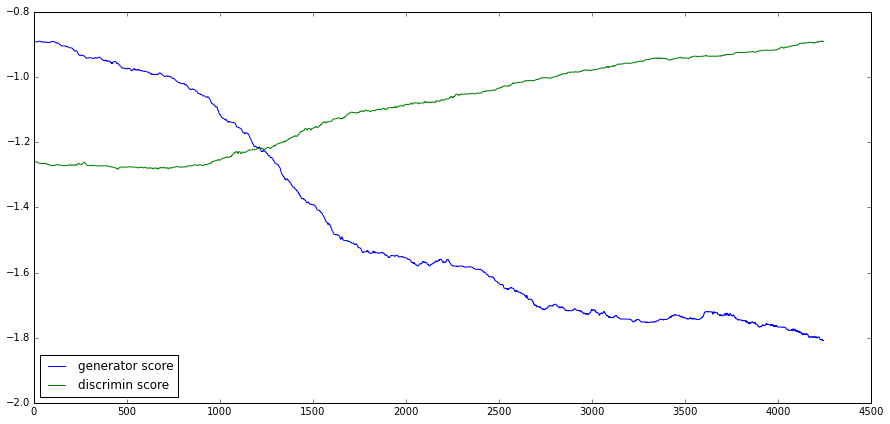

In [87]:
SMOOTHING = 600
def smooth(x):
    return [np.median(x[i-SMOOTHING:i]) for i in range(SMOOTHING, len(x))]
idx_graph = range(len(gen_graph) - SMOOTHING)
plt.figure(figsize=(15,7))
plt.plot(idx_graph, smooth(gen_graph), label="generator score")
plt.plot(idx_graph, smooth(dis_graph), label="discrimin score")
plt.legend(loc="lower left")

# Generated images

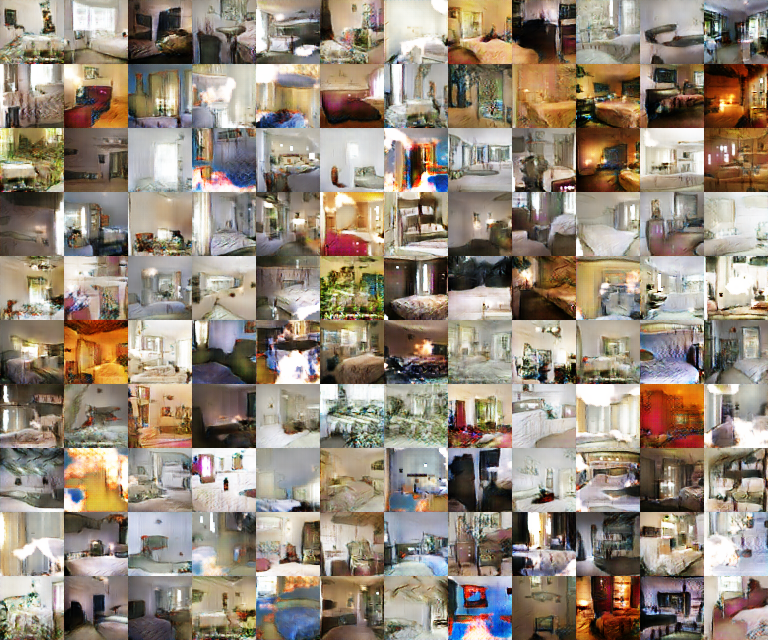

In [11]:
COLLAGE_SIZE = np.array([12,  10])
THUMB_SIZE   = np.array([64, 64])

res = Image.new('RGB', COLLAGE_SIZE * THUMB_SIZE, (255, 255, 255))

for img_x in range(COLLAGE_SIZE[0]):
    for img_y in range(COLLAGE_SIZE[1]):
        i = show_image(example_image(), resize=False).resize(THUMB_SIZE)
        offset = list(THUMB_SIZE * np.array([img_x,     img_y])) + \
                 list(THUMB_SIZE * np.array([img_x + 1, img_y + 1]))
        res.paste(i, offset)
res

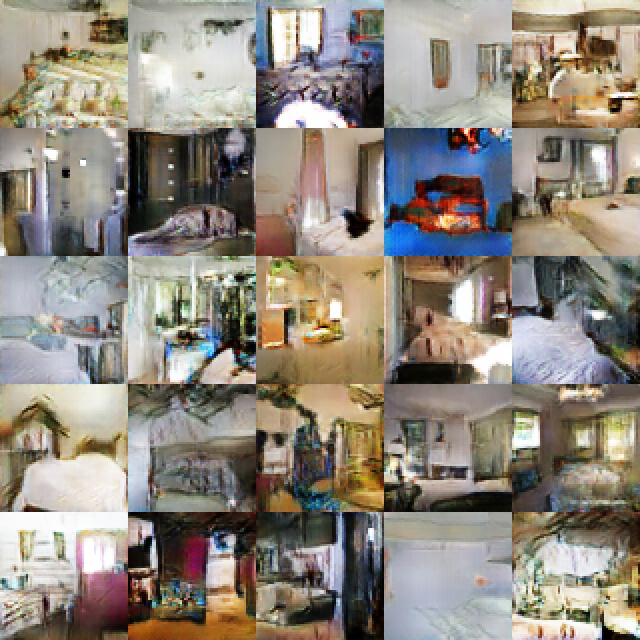

In [12]:
COLLAGE_SIZE = np.array([5,  5])
THUMB_SIZE   = np.array([128, 128])

res = Image.new('RGB', COLLAGE_SIZE * THUMB_SIZE, (255, 255, 255))

for img_x in range(COLLAGE_SIZE[0]):
    for img_y in range(COLLAGE_SIZE[1]):
        i = show_image(example_image(), resize=False).resize(THUMB_SIZE)
        offset = list(THUMB_SIZE * np.array([img_x,     img_y])) + \
                 list(THUMB_SIZE * np.array([img_x + 1, img_y + 1]))
        res.paste(i, offset)
res

# Linear interpolation of images

Images in the middle columns are linear interpolations of images in the first and last columns, i.e. if we used $z_0$ for image in the first column and $z_n$ for the image in the last column, then in order to generate image in the $i$-th column we use

$$ z_i = \frac{i}{n} z_0 + \left( 1-\frac{i}{n} \right) z_n $$

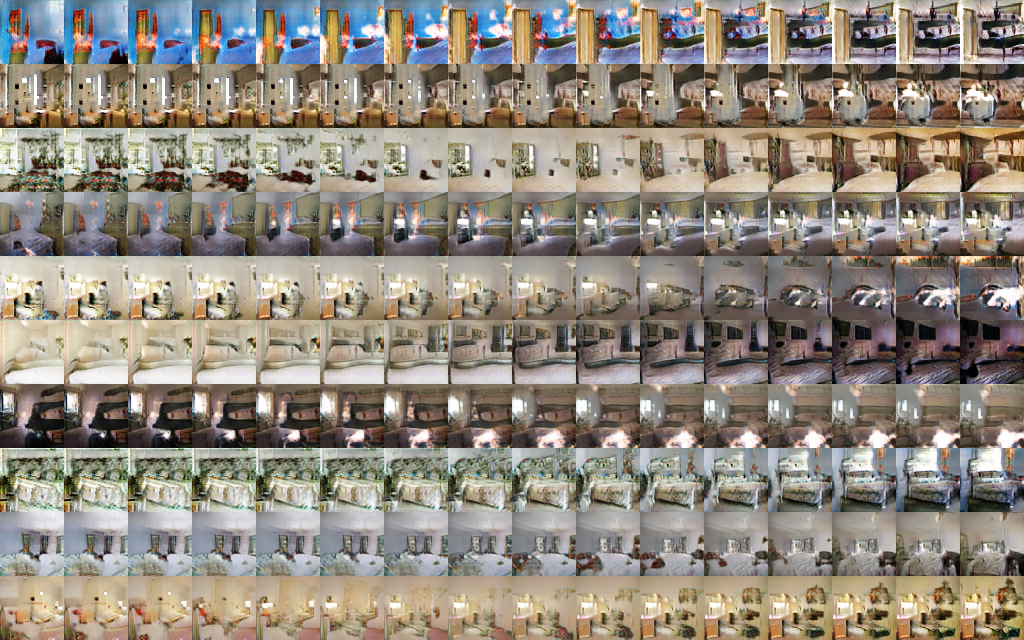

In [13]:
COLLAGE_SIZE = np.array([10, 16])
THUMB_SIZE   = np.array([64, 64])

res = Image.new('RGB', COLLAGE_SIZE[::-1] * THUMB_SIZE, (255, 255, 255))

for img_x in range(COLLAGE_SIZE[0]):
    start_z = np.random.uniform(-1., 1., size=(1, GENERATOR_SEED)).astype(np.float32)
    end_z   = np.random.uniform(-1., 1., size=(1, GENERATOR_SEED)).astype(np.float32)
    for img_y in range(COLLAGE_SIZE[1]):
        alpha     = img_y / COLLAGE_SIZE[1]
        current_z = start_z * alpha + end_z * (1.0 - alpha)
        i = show_image(example_image(current_z), resize=False).resize(THUMB_SIZE)
        offset = list(THUMB_SIZE * np.array([img_y,     img_x])) + \
                 list(THUMB_SIZE * np.array([img_y + 1, img_x + 1]))
        res.paste(i, offset)
res

# TODO 

- showcase some form of arithmetic, e.g.

$$ (\text{blue bed with lamp}) - (\text{blue bed without lamp}) = (\text{red bed with lamp}) - (\text{red bed without lamp}) $$

- showcase rotation as linear property
- showcase roboustness of z space encoding given the image. 
- given 40 epochs of training I was getting somewhat reasonable generated images for cifar10 (even though there was little examples). Maybe if I do this experiment for LSUN in resolution 256x256 I will get reasonable generated images after X epochs of training. It would be insanely cool, any volunteers for writing multi-GPU version?